## Mobile, AL 2021 City Council Election Results and Boundaries

### Sections
- <a href="#join"> Read in Input Files and Join</a><br>
- <a href="#shp">Create Ward Boundaries</a><br>
- <a href="#maup">Join with Election Returns</a><br>
- <a href="#exp">Export Cleaned Datasets</a><br>

#### Sources

- [Mobile, AL 2021 Municipal Election Returns, Ward Level PDF](https://www.cityofmobile.org/uploads/2109010853462021OFFICIALELECTIONR001.pdf)) 
- [Mobile, AL 2021 Adopted Voting Wards PDF Map](https://open-government-cityofmobile.hub.arcgis.com/documents/cityofmobile::council-districts-8-5x11/explore)
- [RDH Alabama 2020 Census Block Boundaries](https://redistrictingdatahub.org/dataset/alabama-block-boundaries-2020/)
-[Census Place Boundaries for City of Homewood](https://data.census.gov/map/160XX00US0103076?layer=VT_2022_160_V2_PY_D1&loc=43.3751,-113.1138,z4.0000)

In [1]:
import pandas as pd
import geopandas as gp
import os
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

<p><a name="join"></a></p>

### Read in input files

Election returns were transcribed from PDF to machine readable format, and hand checked checked for accuracy.

In [2]:
#Election Returns
er = pd.read_csv("./raw-from-source/MOBILE_ER_PROC.csv")
er.head(2)

,UNIQUE_ID,MNCIPAL,DISTRICT,G21MYRNELY,G21MYRNFIN,G21MYRNRIC,G21MYRNSTI,G21MYRNYOU,GCTC1NBER,GCTC1NHOL,GCTC1NPEN,GCTC1NTHH,GCTC1NTHC,GCTC1NWES,GCTC1NWRI,GCTC2NCAF,GCTC2NCAR,GCTC2NHIL,GCTC2NMAN,GCTC2NMCK,GCTC2NMIN,GCTC3NCAR,GCTC3NSMA,GCTC4NRET,GCTC4NREY,GCTC5NCOP,GCTC5NDAV,GCTC5NWRI,GCTC6NDUG,GCTC6NJON,GCTC6NPEN,GCTC6NWOO,GCTC7NBAR,GCTC7NGRE
0,MOBILE_CITYCOUNC-ALG,Mobile City,ALG,142,4876,7568,21365,239,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,MOBILE_CITYCOUNC-D1,Mobile City,1,0,0,0,0,0,206,262,1652,1320,1080,123,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
#Alabama 2020 Census blocks
alblocks = gp.read_file("./raw-from-source/al_b_2020_bound/al_b_2020_bound.shp")
# Subset to just Mobile County, FIP code 097
mobileblocks = alblocks[alblocks['COUNTYFP20'] == '097'][['GEOID20', 'geometry']]
#mobileblocks.to_file("./raw-from-source/mobileblocks.geojson")

In [4]:
len(mobileblocks)

9916

<AxesSubplot:>

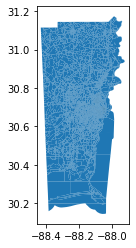

In [5]:
mobileblocks.plot()

<AxesSubplot:>

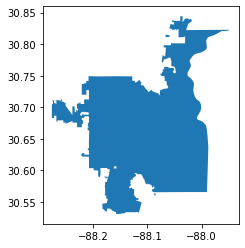

In [6]:
#Census Place Mobile boundaries
shp = gp.read_file("./raw-from-source/tl_2020_01_place/tl_2020_01_place.shp")
mobile = shp[shp['NAME'] == 'Mobile']
mobile.plot()

In [7]:
#Clip Mobile County blocks to Mobile, AL boundaries from Census
clipped = gp.clip(mobileblocks, mobile.geometry)
len(clipped.GEOID20.unique()) # number of unique census blocks
clipped.to_file("./raw-from-source/mobile_cbp.geojson")

<AxesSubplot:>

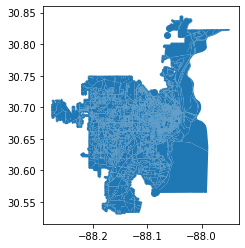

In [8]:
clipped.plot()

<p><a name="shp"></a></p>

### Create Ward Boundaries and Block Assignment File
In QGIS, PDF map of city council wards was georeferenced. Mobile 2020 Census place blocks were overlaid, and each ward shape was created by selecting
1. Every census block that was wholly contained within ward shape for all 7 wards
2. 119 Additional census blocks that were contained within ward shape 6, but not contained in 2020 census place.
3. 39 Additional census blocks that were contained within ward shape 7, but not contained in 2020 census place.

In [13]:
# Read in shapefiles of all blocks from census place
mobile_blocks = gp.read_file("./raw-from-source/mobile_wards.geojson")
# Read in shapefiles for additional blocks
d6_add = gp.read_file("./raw-from-source/add_d6.geojson")
d7_add = gp.read_file("./raw-from-source/add_d7.geojson")

In [14]:
# Ensure column types are the same
d6_add['DISTRICT'] = d6_add['DISTRICT'].astype('int64')
d7_add['DISTRICT'] = d7_add['DISTRICT'].astype('int64')
mobile_blocks['DISTRICT'] = mobile_blocks['DISTRICT'].astype('int64')

In [15]:
# Combine additional blocks
mob_all_blocks = mobile_blocks.append([d6_add, d7_add], ignore_index=True)
len(mob_all_blocks)

4363

In [16]:
#Check
mob_all_blocks['DISTRICT'].unique()

array([2, 1, 7, 5, 6, 3, 4], dtype=int64)

In [17]:
# Create BAF
baf = mob_all_blocks[['GEOID20', 'DISTRICT']]
baf.columns = ['GEOID20', 'DISTRICT']
#Check for duplicates
baf[baf['GEOID20'].duplicated()]

,GEOID20,DISTRICT
4344,010970064023006,7


In [18]:
# Drop duplicates
baf_no_dup = baf.drop_duplicates(subset=['GEOID20'])
mob_all_blocks_2 = mob_all_blocks.drop_duplicates(subset=['GEOID20'])

In [19]:
#Check for duplicates
baf_no_dup[baf_no_dup['GEOID20'].duplicated()]

,GEOID20,DISTRICT


In [20]:
#check
mob_all_blocks_2[mob_all_blocks_2['GEOID20'].duplicated()]

,GEOID20,DISTRICT,geometry


Dissolve block shapefile into at large shape

In [21]:
mob_alg = mob_all_blocks_2.dissolve()

<AxesSubplot:>

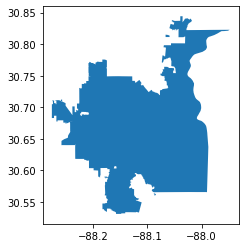

In [22]:
#Drop GEOID20 Column
mob_alg = mob_alg.drop('GEOID20', axis = 1)
#At large district
mob_alg['DISTRICT'] = 'ALG'
mob_alg.plot()

Dissolve block shapefile into ward shapes

In [23]:
#dissolve by ward
mob_wards = mob_all_blocks_2.dissolve(by='DISTRICT').drop('GEOID20', axis = 1).reset_index()
#rename columns
mob_wards.columns = ['DISTRICT', 'geometry']
mob_wards

,DISTRICT,geometry
0,1,"POLYGON ((-88.09681 30.72464, -88.09644 30.724..."
1,2,"MULTIPOLYGON (((-88.07940 30.66235, -88.07959 ..."
2,3,"POLYGON ((-88.08436 30.56097, -88.08476 30.560..."
3,4,"POLYGON ((-88.13006 30.53374, -88.13189 30.533..."
4,5,"POLYGON ((-88.16075 30.64878, -88.16084 30.648..."
5,6,"POLYGON ((-88.18654 30.60369, -88.18650 30.596..."
6,7,"MULTIPOLYGON (((-88.16063 30.69125, -88.16075 ..."


<AxesSubplot:>

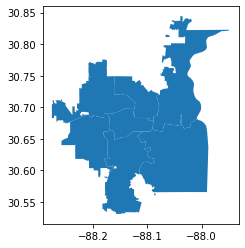

In [24]:
mob_wards.plot()

In [27]:
#Append atlarge df
mob_wards_int = mob_wards.append(mob_alg)
mob_wards_final = mob_wards_int.dissolve(by='DISTRICT').reset_index()

In [28]:
mob_wards_final

,DISTRICT,geometry
0,1,"POLYGON ((-88.09681 30.72464, -88.09644 30.724..."
1,2,"MULTIPOLYGON (((-88.07959 30.66237, -88.08028 ..."
2,3,"POLYGON ((-88.08436 30.56097, -88.08476 30.560..."
3,4,"POLYGON ((-88.13006 30.53374, -88.13189 30.533..."
4,5,"POLYGON ((-88.16075 30.64878, -88.16084 30.648..."
5,6,"POLYGON ((-88.18654 30.60369, -88.18650 30.596..."
6,7,"MULTIPOLYGON (((-88.14034 30.72049, -88.13987 ..."
7,ALG,"MULTIPOLYGON (((-88.14088 30.53303, -88.14091 ..."


### Join with Election Returns

In [31]:
#make sure ward column types are same
er['DISTRICT'] = er['DISTRICT'].astype('str')
mob_wards_final['DISTRICT'] = mob_wards_final['DISTRICT'].astype('str')

In [32]:
# merge
mob_pber = er.merge(mob_wards_final, on='DISTRICT', how = 'right', indicator=True)

In [33]:
#check indicator to see if merge was successful
mob_pber._merge.value_counts()

both          8
left_only     0
right_only    0
Name: _merge, dtype: int64

In [34]:
#Drop merge column
mob_pber.drop(labels = ['_merge'], axis = 1, inplace = True)

In [35]:
#Geodf
mob_pber = gp.GeoDataFrame(mob_pber, geometry='geometry')
#check
type(mob_pber)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

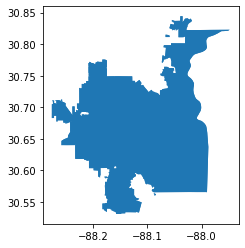

In [36]:
mob_pber.plot()

In [38]:
mob_pber.head()

,UNIQUE_ID,MNCIPAL,DISTRICT,G21MYRNELY,G21MYRNFIN,G21MYRNRIC,G21MYRNSTI,G21MYRNYOU,GCTC1NBER,GCTC1NHOL,GCTC1NPEN,GCTC1NTHH,GCTC1NTHC,GCTC1NWES,GCTC1NWRI,GCTC2NCAF,GCTC2NCAR,GCTC2NHIL,GCTC2NMAN,GCTC2NMCK,GCTC2NMIN,GCTC3NCAR,GCTC3NSMA,GCTC4NRET,GCTC4NREY,GCTC5NCOP,GCTC5NDAV,GCTC5NWRI,GCTC6NDUG,GCTC6NJON,GCTC6NPEN,GCTC6NWOO,GCTC7NBAR,GCTC7NGRE,geometry
0,MOBILE_CITYCOUNC-D1,Mobile City,1,0,0,0,0,0,206,262,1652,1320,1080,123,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-88.09681 30.72464, -88.09644 30.724..."
1,MOBILE_CITYCOUNC-D2,Mobile City,2,0,0,0,0,0,0,0,0,0,0,0,0,354,1085,190,2279,163,732,0,0,0,0,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((-88.07959 30.66237, -88.08028 ..."
2,MOBILE_CITYCOUNC-D3,Mobile City,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,335,2896,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-88.08436 30.56097, -88.08476 30.560..."
3,MOBILE_CITYCOUNC-D4,Mobile City,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1857,3432,0,0,0,0,0,0,0,0,0,"POLYGON ((-88.13006 30.53374, -88.13189 30.533..."
4,MOBILE_CITYCOUNC-D5,Mobile City,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,365,3098,660,0,0,0,0,0,0,"POLYGON ((-88.16075 30.64878, -88.16084 30.648..."


<AxesSubplot:>

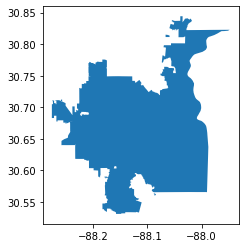

In [48]:
alg_mob = mob_pber[mob_pber['DISTRICT'] == 'ALG']
dist_mob = mob_pber[mob_pber['DISTRICT'] != 'ALG']
alg_mob.plot()

In [49]:
dist_mob

,UNIQUE_ID,MNCIPAL,DISTRICT,G21MYRNELY,G21MYRNFIN,G21MYRNRIC,G21MYRNSTI,G21MYRNYOU,GCTC1NBER,GCTC1NHOL,GCTC1NPEN,GCTC1NTHH,GCTC1NTHC,GCTC1NWES,GCTC1NWRI,GCTC2NCAF,GCTC2NCAR,GCTC2NHIL,GCTC2NMAN,GCTC2NMCK,GCTC2NMIN,GCTC3NCAR,GCTC3NSMA,GCTC4NRET,GCTC4NREY,GCTC5NCOP,GCTC5NDAV,GCTC5NWRI,GCTC6NDUG,GCTC6NJON,GCTC6NPEN,GCTC6NWOO,GCTC7NBAR,GCTC7NGRE,geometry
0,MOBILE_CITYCOUNC-D1,Mobile City,1,0,0,0,0,0,206,262,1652,1320,1080,123,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-88.09681 30.72464, -88.09644 30.724..."
1,MOBILE_CITYCOUNC-D2,Mobile City,2,0,0,0,0,0,0,0,0,0,0,0,0,354,1085,190,2279,163,732,0,0,0,0,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((-88.07959 30.66237, -88.08028 ..."
2,MOBILE_CITYCOUNC-D3,Mobile City,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,335,2896,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-88.08436 30.56097, -88.08476 30.560..."
3,MOBILE_CITYCOUNC-D4,Mobile City,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1857,3432,0,0,0,0,0,0,0,0,0,"POLYGON ((-88.13006 30.53374, -88.13189 30.533..."
4,MOBILE_CITYCOUNC-D5,Mobile City,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,365,3098,660,0,0,0,0,0,0,"POLYGON ((-88.16075 30.64878, -88.16084 30.648..."
5,MOBILE_CITYCOUNC-D6,Mobile City,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,661,2500,436,2162,0,0,"POLYGON ((-88.18654 30.60369, -88.18650 30.596..."
6,MOBILE_CITYCOUNC-D7,Mobile City,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1094,4432,"MULTIPOLYGON (((-88.14034 30.72049, -88.13987 ..."


<p><a name="exp"></a></p>

### Export Cleaned Datasets

In [54]:
if not os.path.exists("./AL21_MOBILE_PBER/AL21_MOBILE_DIST_PBER"):
    os.mkdir("./AL21_MOBILE_PBER/AL21_MOBILE_DIST_PBER")

if not os.path.exists("./AL21_MOBILE_PBER/AL21_MOBILE_ALG_PBER"):
    os.mkdir("./AL21_MOBILE_PBER/AL21_MOBILE_ALG_PBER")

dist_mob.to_file("./AL21_MOBILE_PBER/AL21_MOBILE_DIST_PBER/AL21_MOBILE_DIST_PBER.shp")
alg_mob.to_file("./AL21_MOBILE_PBER/AL21_MOBILE_ALG_PBER/AL21_MOBILE_ALG_PBER.shp")
baf.to_csv('./AL21_MOBILE_PBER/AL21_MOBILE_BAF.csv', index=False)